In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.4.1


In [3]:
# Set parameters here 
INPUT_SIZE = 224
BATCH_SIZE = 16

SEED = 12345
np.random.seed(SEED)

path = r'E:/work/data/101_ObjectCategories'
classes = os.listdir(path)
myclasses = classes
myclasses.remove('BACKGROUND_Google')
myclasses.remove('Faces')

NUMCLASSES = len(myclasses)

mapping = {}
for i in range(NUMCLASSES):
    mapping[i] = myclasses[i]


In [4]:
from skimage import exposure

def preprocess(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    return img_rescale


In [5]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=True,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=True,
                                zca_epsilon=1e-06,
                                rotation_range=5,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.5,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=1./255,
                                preprocessing_function=None,#preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )


In [6]:
# Make a dtaframe with all the file paths and labels
allfilelist = []
alllabels = []
alllabels_word = []
for i in range(NUMCLASSES):
    filepath = path + '/' + myclasses[i]
    filelist = os.listdir(filepath)
    for f in filelist:
        if f.lower() == 'thumbs.db':
            continue
        
        fullpath = filepath + '/' + f
        allfilelist.append(fullpath)
        alllabels.append(i)
        alllabels_word.append(myclasses[i])
        
d = {'filename':allfilelist,'labelnum':alllabels,'label':alllabels_word}

df = pd.DataFrame(d)
df.tail()
    


,filename,labelnum,label
8237,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang
8238,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang
8239,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang
8240,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang
8241,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang


In [7]:
# This next line is to use only some x% of the data
df = df.sample(frac=1.0)
df.head()

,filename,labelnum,label
7711,E:/work/data/101_ObjectCategories/umbrella/ima...,92,umbrella
1572,E:/work/data/101_ObjectCategories/camera/image...,13,camera
1531,E:/work/data/101_ObjectCategories/butterfly/im...,12,butterfly
8044,E:/work/data/101_ObjectCategories/wheelchair/i...,95,wheelchair
7602,E:/work/data/101_ObjectCategories/trilobite/im...,91,trilobite


In [8]:
print(df['label'].value_counts())

airplanes       800
Motorbikes      798
Faces_easy      435
watch           239
Leopards        200
               ... 
gerenuk          34
garfield         34
binocular        33
metronome        32
inline_skate     31
Name: label, Length: 100, dtype: int64


In [9]:


training_set = train_datagen.flow_from_dataframe(
                                            dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe( dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='validation',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                            )

Found 6594 validated image filenames belonging to 100 classes.
Found 1648 validated image filenames belonging to 100 classes.


In [10]:
from tensorflow.keras.applications import VGG16


#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000175BB0E7E50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000175BB66A460> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000175BB66AC40> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000175BB66A8E0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000175BB21C430> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000175BB22B5E0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000175BB22B700> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000175BB235FA0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000175BB243100> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000175BB248B20> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000175BB22B850> False
<tensorflow.python.

In [11]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUMCLASSES, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
Total params: 40,508,324
Trainable params: 32,873,060
Non-trainable params: 7,635,264
_________________________________________________________________


In [13]:
#Training

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
num_epochs = 10
history = model.fit(training_set, steps_per_epoch=len(training_set), epochs=num_epochs, validation_data=validation_set,
                   validation_steps = len(validation_set))

model.save_weights("model-normalized-aug-vgg.h5")
print("Saved model to disk after",num_epochs,"epochs.")
# model.load_weights('model-normalized-aug.h5')

Epoch 1/10
413/413 [==============================] - 411s 962ms/step - loss: 2.3488 - acc: 0.5125 - val_loss: 0.4719 - val_acc: 0.8762
Epoch 2/10
413/413 [==============================] - 214s 518ms/step - loss: 0.3947 - acc: 0.8949 - val_loss: 0.3700 - val_acc: 0.9029
Epoch 3/10
413/413 [==============================] - 233s 564ms/step - loss: 0.2058 - acc: 0.9446 - val_loss: 0.3808 - val_acc: 0.9084
Epoch 4/10
413/413 [==============================] - 233s 565ms/step - loss: 0.1255 - acc: 0.9673 - val_loss: 0.5357 - val_acc: 0.9084
Epoch 5/10
413/413 [==============================] - 227s 549ms/step - loss: 0.1322 - acc: 0.9701 - val_loss: 0.4428 - val_acc: 0.9059
Epoch 6/10
413/413 [==============================] - 223s 540ms/step - loss: 0.0949 - acc: 0.9778 - val_loss: 0.9655 - val_acc: 0.8829
Epoch 7/10
413/413 [==============================] - 221s 535ms/step - loss: 0.1185 - acc: 0.9744 - val_loss: 0.9223 - val_acc: 0.8932
Epoch 8/10
413/413 [============================

In [14]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

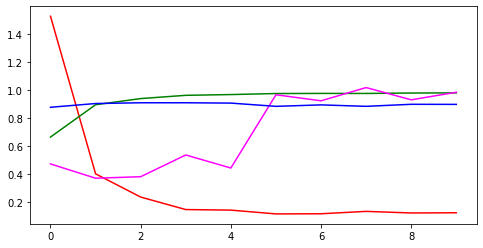

In [15]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['acc'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_acc'],color='blue')
plt.show()

Actual Class: sea_horse
Predictions:
sea_horse : 0.56861234
elephant : 0.4053007
strawberry : 0.009497442
platypus : 0.0063685747
brain : 0.0034148458


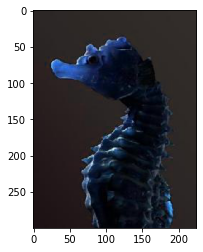

In [17]:
# Get random image
classnum = np.random.randint(NUMCLASSES)
folder = path + '/' + myclasses[classnum]
filelist = os.listdir(folder)
i = np.random.randint(len(filelist))
while filelist[i].lower()=='thumbs.db':
    i = np.random.randint(len(filelist))
image_path = folder + '/' + filelist[i]
image = cv2.imread(image_path)
plt.imshow(image)

# Prepare image
img = tf.keras.preprocessing.image.load_img(image_path)
img = tf.keras.preprocessing.image.img_to_array(img)
#img = preprocess(img)
img = cv2.resize(img,(INPUT_SIZE,INPUT_SIZE))
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

# Print what the top predicted class is
#print(img_tensor.shape)
preds = model.predict(img_tensor,steps=1)
preds = preds.flatten()
#print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]
print('Actual Class:',myclasses[classnum])
print('Predictions:')
for i in range(5):
    if preds[order[i]] == 0:
        break
    else:
        print(myclasses[order[i]], ':', preds[order[i]])
